In [ ]:
%pip install matplotlib xgboost scipy

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from requests import get
import xgboost as xgb
import scipy

In [6]:
pets = ['PET_AMMONITE', 'PET_ARMADILLO', 'PET_BABY_YETI', 'PET_BAL','PET_BAT','PET_BEE','PET_BLACK_CAT','PET_BLAZE','PET_BLUE_WHALE','PET_CHICKEN','PET_DOLPHIN','PET_ELEPHANT','PET_ENDER_DRAGON','PET_ENDERMAN','PET_ENDERMITE','PET_FLYING_FISH','PET_GHOUL','PET_GIRAFFE','PET_GOLDEN_DRAGON','PET_GOLEM','PET_GRIFFIN','PET_GUARDIAN','PET_HORSE','PET_HOUND','PET_JELLYFISH','PET_JERRY','PET_LION','PET_MAGMA_CUBE','PET_MEGALODON','PET_MITHRIL_GOLEM','PET_MONKEY','PET_MOOSHROOM_COW','PET_OCELOT','PET_PARROT','PET_PHOENIX','PET_PIG','PET_PIGMAN','PET_RABBIT','PET_RAT','PET_REINDEER','PET_ROCK','PET_SCATHA','PET_SHEEP','PET_SILVERFISH','PET_SKELETON','PET_SKELETON_HORSE','PET_SNAIL','PET_SNOWMAN','PET_SPIDER','PET_SPIRIT','PET_SQUID','PET_TARANTULA','PET_TIGER','PET_TURTLE','PET_FROST_WISP','PET_WITHER_SKELETON','PET_WOLF','PET_ZOMBIE']

In [9]:
petsData = []

for i in pets:
  for j in range(1):
    res = get('https://sky.coflnet.com/api/auctions/tag/{name}/sold?page={page}&pageSize=1000'.format(name=i, page=j))
    petsData.extend(res.json())

In [10]:
petsData = list(filter(lambda elm: not isinstance(elm, str), petsData))

In [11]:
print(len(petsData))

56959


In [12]:
raw_df = pd.DataFrame(petsData)
raw_df.columns

Index(['uuid', 'count', 'startingBid', 'tag', 'itemName', 'start', 'end',
       'auctioneerId', 'profileId', 'coop', 'coopMembers', 'highestBidAmount',
       'bids', 'anvilUses', 'enchantments', 'nbtData', 'itemCreatedAt',
       'reforge', 'category', 'tier', 'bin', 'flatNbt'],
      dtype='object')

In [14]:
print(pd.to_datetime(pd.to_datetime(raw_df['end']).astype('int64').min()))
pd.to_datetime(pd.to_datetime(raw_df['end']).astype('int64').max())

2023-04-24 21:01:15


Timestamp('2023-05-24 21:19:14')

In [15]:
df = raw_df[['highestBidAmount', 'end']]

In [16]:
# nbtData = pd.json_normalize(raw_df.flatNbt.apply(lambda elm:json.loads(elm.replace('\'', '\"'))))
nbtData = pd.json_normalize(raw_df.flatNbt)

In [17]:
nbtData = nbtData.drop(columns=['uuid', 'uid', 'bossId', 'hideRightClick', 'spawnedFor', 'active', 'blaze_kills'])

In [18]:
nbtData['candyUsed'] = nbtData['candyUsed'].fillna(0)
nbtData = nbtData.fillna('')

In [19]:
nbtData.type = nbtData.type.astype('category')
nbtData.skin = nbtData.skin.astype('category')
nbtData.heldItem = nbtData.heldItem.astype('category')
nbtData.tier = nbtData.tier.astype('category')

nbtData.exp = nbtData.exp.astype(np.float32)
nbtData.hideInfo = nbtData.hideInfo.astype(bool)
nbtData.candyUsed = nbtData.candyUsed.astype(int)

In [20]:
df = pd.concat([nbtData, df], axis=1)

In [21]:
df = df.drop(columns=['end'])
df.head()

,type,exp,tier,hideInfo,heldItem,candyUsed,skin,highestBidAmount
0,AMMONITE,1.174792e+06,LEGENDARY,True,PET_ITEM_FISHING_SKILL_BOOST_UNCOMMON,0,,990000
1,AMMONITE,2.818614e+07,LEGENDARY,True,WASHED_UP_SOUVENIR,1,,27000000
2,AMMONITE,0.000000e+00,LEGENDARY,True,,0,,800000
3,AMMONITE,1.277012e+06,LEGENDARY,True,,0,,2200000
4,AMMONITE,0.000000e+00,LEGENDARY,True,,0,,880000


In [22]:
train_features = df.sample(frac=.8)
test_fitures = df.drop(train_features.index)

In [23]:
train_labels = train_features.pop('highestBidAmount')
test_labels = test_fitures.pop('highestBidAmount')

In [24]:
train = xgb.DMatrix(train_features, label=train_labels, enable_categorical=True);
test = xgb.DMatrix(test_fitures, label=test_labels, enable_categorical=True);

In [25]:
params = {
    'eta': .5,
    'max_depth': 9,
}

In [26]:
regressor = xgb.train(params, dtrain=train)

In [27]:
regressor.save_model('model.json')

In [28]:
predictions = regressor.predict(test)

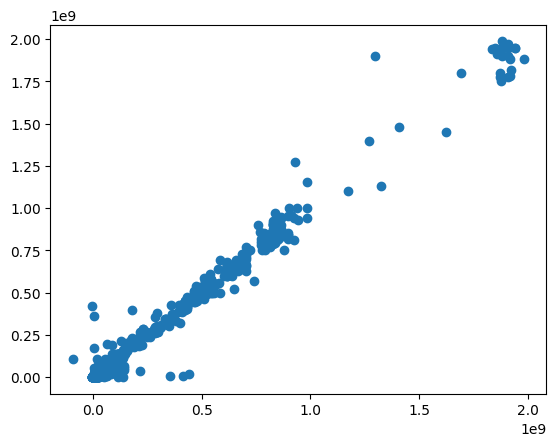

In [30]:
plt.scatter(predictions, test_labels)

In [31]:
error = np.abs(np.subtract(predictions,test_labels.values)).mean()

In [32]:
error

4313213.95411665